**Ejercicio empleando PROMETHEE I**

Alternativas: A,B,C,D.


Criterios (mezcla max/min):
- g1: Costo (minimizar)
- g2: Calidad (maximizar)
- g3: Tiempo (minimizar)
- g4: Riesgo (minimizar)


In [1]:
import numpy as np

# =========================
# Entradas 
# =========================

# Alternativas
alts  = ["A", "B", "C", "D"]
#Criterios 
crits = ["g1", "g2", "g3", "g4"]

# types:  1 = maximizar, -1 = minimizar
types = np.array([-1, 1, -1, -1], dtype=float)

# Matriz desempeño: filas=alternativas, columnas=criterios
X = np.array([
    [100,  70,  45,  7],   # A
    [150,  72,  40,  4],   # B
    [80,  55,  45,  8],   # C
    [140,   65,  45,  5],   # D
], dtype=float)

# Pesos (suman 1)
w = np.array([0.30, 0.30, 0.20, 0.20], dtype=float)

# Umbrales por criterio
q = np.array([5, 1, 2, 0], dtype=float)    # indiferencia
p = np.array([30, 10, 15, 3], dtype=float)    # preferencia

In [2]:
alts = np.array(alts)
X_use = X * types   # todo en sentido "maximizar"
n, m = X_use.shape  # n=4, m=4

# ---------------------------------------------------------
# Helper: lista de pares ordenados 
# {A,B},{B,A},{A,C},{C,A},...,{C,D},{D,C}
# ---------------------------------------------------------
pairs = []
for i in range(n):
    for k in range(i+1, n):
        pairs.append((i, k))
        pairs.append((k, i))

# ---------------------------------------------------------
# Paso 1: diferencias por criterio por par
# d = g(a) - g(b) (ya en sentido maximizar)
# ---------------------------------------------------------
D_rows = []
for (i, k) in pairs:
    d = X_use[i, :] - X_use[k, :]  # (m,)
    D_rows.append(d)

D_rows = np.array(D_rows)  # shape: (12, 4)

# Imprimir tabla Paso 1
print("PASO 1: Tabla de diferencias (d1..d4)")
print("Par\t\t" + "\t".join([f"d{j+1}" for j in range(m)]))
for idx, (i, k) in enumerate(pairs):
    par = f"{{{alts[i]},{alts[k]}}}"
    vals = "\t".join([f"{D_rows[idx, j]:.4f}" for j in range(m)])
    print(f"{par}\t{vals}")

PASO 1: Tabla de diferencias (d1..d4)
Par		d1	d2	d3	d4
{A,B}	50.0000	-2.0000	-5.0000	-3.0000
{B,A}	-50.0000	2.0000	5.0000	3.0000
{A,C}	-20.0000	15.0000	0.0000	1.0000
{C,A}	20.0000	-15.0000	0.0000	-1.0000
{A,D}	40.0000	5.0000	0.0000	-2.0000
{D,A}	-40.0000	-5.0000	0.0000	2.0000
{B,C}	-70.0000	17.0000	5.0000	4.0000
{C,B}	70.0000	-17.0000	-5.0000	-4.0000
{B,D}	-10.0000	7.0000	5.0000	1.0000
{D,B}	10.0000	-7.0000	-5.0000	-1.0000
{C,D}	60.0000	-10.0000	0.0000	-3.0000
{D,C}	-60.0000	10.0000	0.0000	3.0000


In [3]:
# ---------------------------------------------------------
# Paso 2: función de preferencia V-shape con indiferencia (q,p)
# Pj(d) = 0                  si d <= q
#       = (d-q)/(p-q)        si q < d < p
#       = 1                  si d >= p
# y además si d <= 0 => 0 (no hay preferencia)
# ---------------------------------------------------------
def pref_vshape_indiff(d, q, p):
    P = np.zeros_like(d, dtype=float)  # d shape (m,)

    for j in range(d.shape[0]):
        if d[j] <= 0:
            P[j] = 0.0
        elif d[j] <= q[j]:
            P[j] = 0.0
        elif d[j] < p[j]:
            P[j] = (d[j] - q[j]) / (p[j] - q[j])
        else:
            P[j] = 1.0
    return P

P_rows = []
for (i, k) in pairs:
    d = X_use[i, :] - X_use[k, :]
    P_rows.append(pref_vshape_indiff(d, q, p))

P_rows = np.array(P_rows)  # (12,4)

# Imprimir tabla Paso 2
print("\nPASO 2: Tabla de preferencias (P1..P4)")
print("Par\t\t" + "\t".join([f"P{j+1}(d)" for j in range(m)]))
for idx, (i, k) in enumerate(pairs):
    par = f"{{{alts[i]},{alts[k]}}}"
    vals = "\t".join([f"{P_rows[idx, j]:.4f}" for j in range(m)])
    print(f"{par}\t{vals}")


PASO 2: Tabla de preferencias (P1..P4)
Par		P1(d)	P2(d)	P3(d)	P4(d)
{A,B}	1.0000	0.0000	0.0000	0.0000
{B,A}	0.0000	0.1111	0.2308	1.0000
{A,C}	0.0000	1.0000	0.0000	0.3333
{C,A}	0.6000	0.0000	0.0000	0.0000
{A,D}	1.0000	0.4444	0.0000	0.0000
{D,A}	0.0000	0.0000	0.0000	0.6667
{B,C}	0.0000	1.0000	0.2308	1.0000
{C,B}	1.0000	0.0000	0.0000	0.0000
{B,D}	0.0000	0.6667	0.2308	0.3333
{D,B}	0.2000	0.0000	0.0000	0.0000
{C,D}	1.0000	0.0000	0.0000	0.0000
{D,C}	0.0000	1.0000	0.0000	1.0000


In [4]:
# ---------------------------------------------------------
# Paso 3: π(a,b) = Σ wj * Pj(a,b)
# ---------------------------------------------------------

# Preferencia agregada por par (vector de 12 valores)
pi_pairs = P_rows @ w   # (12,)

# Ahora construimos la matriz 4x4 π(a,b)
n = len(alts)
pi_matrix = np.zeros((n, n))

for idx, (i, k) in enumerate(pairs):
    pi_matrix[i, k] = pi_pairs[idx]

# Diagonal en cero
np.fill_diagonal(pi_matrix, 0.0)

# Mostrar tabla
print("\nPASO 3: Matriz π(a,b)")
print("    " + "  ".join(alts))
for i, a in enumerate(alts):
    row = "  ".join([f"{pi_matrix[i,k]:.4f}" for k in range(n)])
    print(f"{a}  {row}")


PASO 3: Matriz π(a,b)
    A  B  C  D
A  0.0000  0.3000  0.3667  0.4333
B  0.2795  0.0000  0.5462  0.3128
C  0.1800  0.3000  0.0000  0.3000
D  0.1333  0.0600  0.5000  0.0000


In [5]:
# ---------------------------------------
# Paso 4: Tabla de flujos
# ---------------------------------------

phi_plus  = pi_matrix.sum(axis=1) / (n - 1)
phi_minus = pi_matrix.sum(axis=0) / (n - 1)

print("\nPASO 4: Tabla de Flujos")
print("Alternativa\tϕ+(a)\t\tϕ−(a)")

for i, a in enumerate(alts):
    print(f"{a}\t\t{phi_plus[i]:.4f}\t\t{phi_minus[i]:.4f}")



PASO 4: Tabla de Flujos
Alternativa	ϕ+(a)		ϕ−(a)
A		0.3667		0.1976
B		0.3795		0.2200
C		0.2600		0.4709
D		0.2311		0.3487


**Solución utilizando la librería de Python pyDecision**

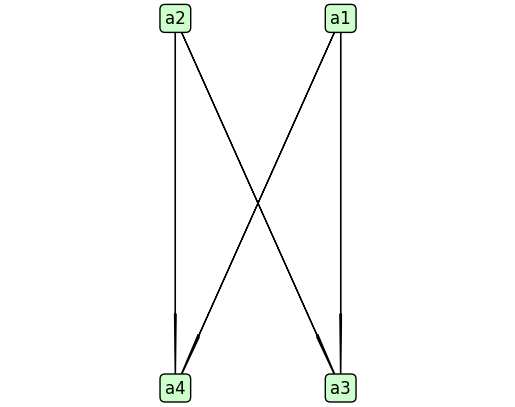

π(a,b):
 [[0.       0.3      0.366667 0.433333]
 [0.279487 0.       0.546154 0.312821]
 [0.18     0.3      0.       0.3     ]
 [0.133333 0.06     0.5      0.      ]]

phi+ : [0.366667 0.379487 0.26     0.231111]
phi- : [0.197607 0.22     0.47094  0.348718]

cp (P+/I/R):
 [['-' 'R' 'P+' 'P+']
 ['R' '-' 'P+' 'P+']
 ['-' '-' '-' 'R']
 ['-' '-' 'R' '-']]


In [6]:
import numpy as np
from pyDecision.algorithm.p_i import preference_degree, promethee_i

# =========================
# Datos de entrada
# =========================
alts  = ["A", "B", "C", "D"]
types = np.array([-1, 1, -1, -1], dtype=float)

X = np.array([
    [100, 70, 45, 7],  # A
    [150, 72, 40, 4],  # B
    [80,  55, 45, 8],  # C
    [140, 65, 45, 5],  # D
], dtype=float)

w = np.array([0.30, 0.30, 0.20, 0.20], dtype=float)
q = np.array([5, 1, 2, 0], dtype=float)
p = np.array([30, 10, 15, 3], dtype=float)

# Parámetro S (solo se usa en gaussian/otras); aquí no se usa
S = np.zeros(4, dtype=float)

# Función por criterio (t5 = V-shape con indiferencia q,p)
F = ["t5", "t5", "t5", "t5"]

# Convertir todo a maximizar
dataset = X * types
n = len(alts)

# PASO 3: matriz π(a,b)
pi = preference_degree(dataset, w, q, S, p, F)
np.fill_diagonal(pi, 0.0)

# PASO 4: flujos
phi_plus  = pi.sum(axis=1) / (n - 1)
phi_minus = pi.sum(axis=0) / (n - 1)

# PASO 5: relación PROMETHEE I (P+, I, R)
cp = promethee_i(dataset, w, q, S, p, F, graph=True)

print("π(a,b):\n", np.round(pi, 6))
print("\nphi+ :", np.round(phi_plus, 6))
print("phi- :", np.round(phi_minus, 6))
print("\ncp (P+/I/R):\n", cp)


In [7]:
# =========================
# Paso 5: Relación PROMETHEE I (por parejas) 
# =========================

map_to_col = {"P+": "≻", "I": "∼", "R": "∥", "-": None}

pairs_undirected = [("A","B"), ("A","C"), ("A","D"), ("B","C"), ("B","D"), ("C","D")]
idx = {name:i for i, name in enumerate(alts)}

print("\nPaso 5: Relación PROMETHEE I (por parejas)")
print("Pareja {a,b}\t\t≻\t∼\t∥")

for a, b in pairs_undirected:
    i, j = idx[a], idx[b]

    rab = map_to_col.get(str(cp[i, j]), None)  # a vs b
    rba = map_to_col.get(str(cp[j, i]), None)  # b vs a

    # Determinar columnas:
    col_pref = "v" if ("≻" in (rab, rba)) else "f"
    col_ind  = "v" if ("∼" in (rab, rba)) else "f"
    col_inc  = "v" if ("∥" in (rab, rba)) else "f"

    print(f"{{{a},{b}}}, {{{b},{a}}}\t{col_pref}\t{col_ind}\t{col_inc}")



Paso 5: Relación PROMETHEE I (por parejas)
Pareja {a,b}		≻	∼	∥
{A,B}, {B,A}	f	f	v
{A,C}, {C,A}	v	f	f
{A,D}, {D,A}	v	f	f
{B,C}, {C,B}	v	f	f
{B,D}, {D,B}	v	f	f
{C,D}, {D,C}	f	f	v
